In [21]:
import numpy as np
import pandas as pd
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Input, Concatenate
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from data.create_data_df import create_data_df


In [22]:
df = create_data_df()
df = df.dropna()

/Users/alextseng/Documents/ucy-pv-forecasting/create_data_df.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2022_2023 = pd.read_csv('./UCYdemo_2022_2023.csv', parse_dates=[0])


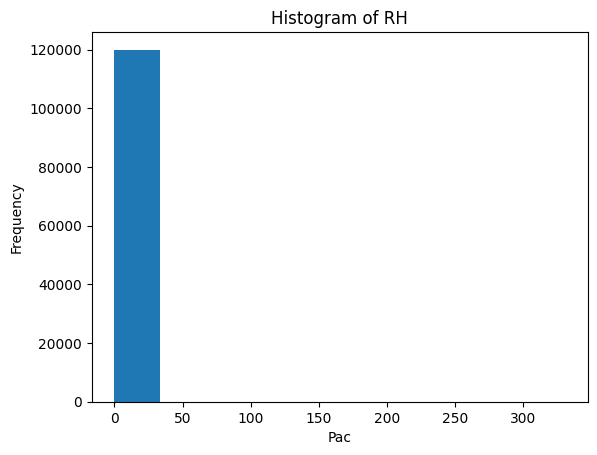

In [23]:

plt.hist(df['Pac'], bins=10)
plt.xlabel('Pac')
plt.ylabel('Frequency')
plt.title('Histogram of RH')
plt.show()

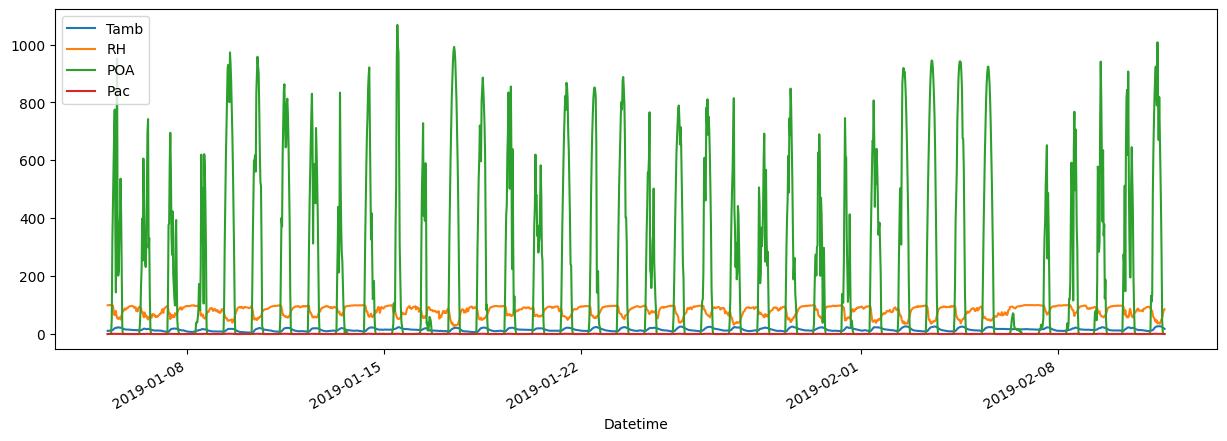

In [24]:
_ = df.loc[200:2000].plot(x='Datetime', style='-', figsize=(15,5))

In [25]:
# Normalize the data


In [26]:
# func to add time series columns
# def create_time_series_columns(df, lag=3, series_columns=['Pac'], label = False):
#     for i in range(1, lag + 1):
#         for col in series_columns:
#             df[f'{col}(t-{i})'] = df[col].shift(i)

In [27]:
# create_time_series_columns(df, lag=4, series_columns=['Pac'])
# df.head(10)

In [28]:
def transform_time_var(var, div: float):
    normalized_var = var / div
    var_sin = np.sin(2 * np.pi * normalized_var)
    var_cos = np.cos(2 * np.pi * normalized_var)
    return var_sin, var_cos

# turn datetime into day, year, month, hour, minute
def datetime_to_columns(df, datetime_column='Datetime'):
    new_df = df.copy()
    new_df['month_sin'], new_df['month_cos'] = transform_time_var(df[datetime_column].dt.month, 12)
    new_df['min_sin'], new_df['min_cos'] = transform_time_var(
        df[datetime_column].dt.hour * 60 + df[datetime_column].dt.minute, 
        1440                # 24 hours * 60 minutes
    )
    
    return new_df

In [29]:
split_date = '01-Jul-2023'
df_train = df.loc[df.Datetime <= split_date].copy()
df_test = df.loc[df.Datetime > split_date].copy()

In [30]:
df_train = datetime_to_columns(df_train, 'Datetime')
df_test = datetime_to_columns(df_test, 'Datetime')

In [31]:
# Func to create train and test data
def create_samples(df, lag, target_column='Pac'):

    X_train = []
    y_train = []
    for i in range(lag, len(df)):
        X_train.append(df.iloc[i-lag:i])
        y_train.append(df[target_column].iloc[i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    print(X_train[0])
    return X_train, y_train

In [32]:
def create_inputs(df, lag, target_column='Pac'):
    X_time_power, _ = create_samples(df[['Pac']], lag, target_column='Pac')
    X_features = (df
              .drop(columns=['Pac'])
              .iloc[lag:]
            )   
    y = df.iloc[lag:]['Pac'] 
    return X_time_power, X_features, y

In [33]:

LAG = 5
X_lstm_train, X_features_train, y_train = create_inputs(df_train.drop(columns=['Datetime']), LAG)
X_lstm_test, X_features_test, y_test = create_inputs(df_test.drop(columns=['Datetime']), LAG)


(111098, 5, 1)
[[0.001474]
 [0.001412]
 [0.00167 ]
 [0.001537]
 [0.001181]]
(8826, 5, 1)
[[0.005]
 [0.005]
 [0.005]
 [0.005]
 [0.005]]


In [34]:
# LSTM branch
lstm_input = Input(shape=(LAG, X_lstm_train.shape[2]))
lstm_branch = LSTM(units=8)(lstm_input)
# lstm_branch = LSTM(units=32)(lstm_branch)
lstm_branch = Dense(units=1)(lstm_branch)

# Additional features branch
additional_features_input = Input(shape=(X_features_train.shape[1],))
# Assuming 'num_additional_features' is the number of additional features

# Concatenate the LSTM output and additional features
concatenated = Concatenate()([lstm_branch, additional_features_input])

# Final dense layer after concatenation
layer_1 = Dense(units=32)(concatenated)
final_output = Dense(units=1)(layer_1)

# Build the model
model = Model(inputs=[lstm_input, additional_features_input], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Train the model
history = model.fit([X_lstm_train, X_features_train], y_train, epochs=20, batch_size=32)

Epoch 1/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 4s 965us/step - loss: 22.4500
Epoch 2/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 916us/step - loss: 0.7874
Epoch 3/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - loss: 2.3758
Epoch 4/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 908us/step - loss: 0.8621
Epoch 5/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 939us/step - loss: 2.6149
Epoch 6/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - loss: 0.6967
Epoch 7/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - loss: 0.0658
Epoch 8/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - loss: 0.2801
Epoch 9/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - loss: 1.4280
Epoch 10/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - loss: 0.9631
Epoch 11/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - loss: 0.6413
Epoch 12/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 871us/step - loss: 0.7905
Epoch 13/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 875us/step - loss: 2.1026
Epoch 14/20
3472/3472 ━━━━━━━━━━━━━━━━━━━━ 3s 884us/step - loss: 1.7218


In [36]:
predictions = model.predict([X_lstm_test, X_features_test])
print(X_lstm_test.shape)

# Reshape predictions to an array
predictions = predictions.flatten()

# Evaluate the model
mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
(8826, 5, 1)
Mean Squared Error: 0.0034820110949287447


In [37]:
with_predicts = df_test.iloc[LAG:].copy()

with_predicts['Predictions'] = predictions
with_predicts.head(10)

,Datetime,Tamb,RH,POA,Pac,month_sin,month_cos,min_sin,min_cos,Predictions
111108,2023-07-01 03:00:00,26.70,67.23,0.000,0.005,-0.5,-0.866025,0.707107,7.071068e-01,0.012425
111109,2023-07-01 03:30:00,26.28,67.03,0.000,0.005,-0.5,-0.866025,0.793353,6.087614e-01,0.020440
111110,2023-07-01 04:00:00,25.90,67.24,0.000,0.005,-0.5,-0.866025,0.866025,5.000000e-01,0.028794
111111,2023-07-01 04:30:00,25.57,67.19,0.000,0.005,-0.5,-0.866025,0.923880,3.826834e-01,0.037673
111112,2023-07-01 05:00:00,25.28,67.67,0.007,0.005,-0.5,-0.866025,0.965926,2.588190e-01,0.046519
111113,2023-07-01 05:30:00,25.24,67.19,0.030,0.005,-0.5,-0.866025,0.991445,1.305262e-01,0.056170
111114,2023-07-01 06:00:00,25.71,63.91,0.080,0.042,-0.5,-0.866025,1.000000,6.123234e-17,0.067700
111115,2023-07-01 06:30:00,26.94,58.92,0.161,0.117,-0.5,-0.866025,0.991445,-1.305262e-01,0.110168
111116,2023-07-01 07:00:00,28.71,51.00,0.244,0.212,-0.5,-0.866025,0.965926,-2.588190e-01,0.193772
111117,2023-07-01 07:30:00,30.36,44.17,0.333,0.296,-0.5,-0.866025,0.923880,-3.826834e-01,0.302160


In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
error = mean_absolute_percentage_error(
    y_true=with_predicts.loc[with_predicts["Pac"] > 0.2, "Pac"],
    y_pred=with_predicts.loc[with_predicts["Pac"] > 0.2, "Predictions"],
)

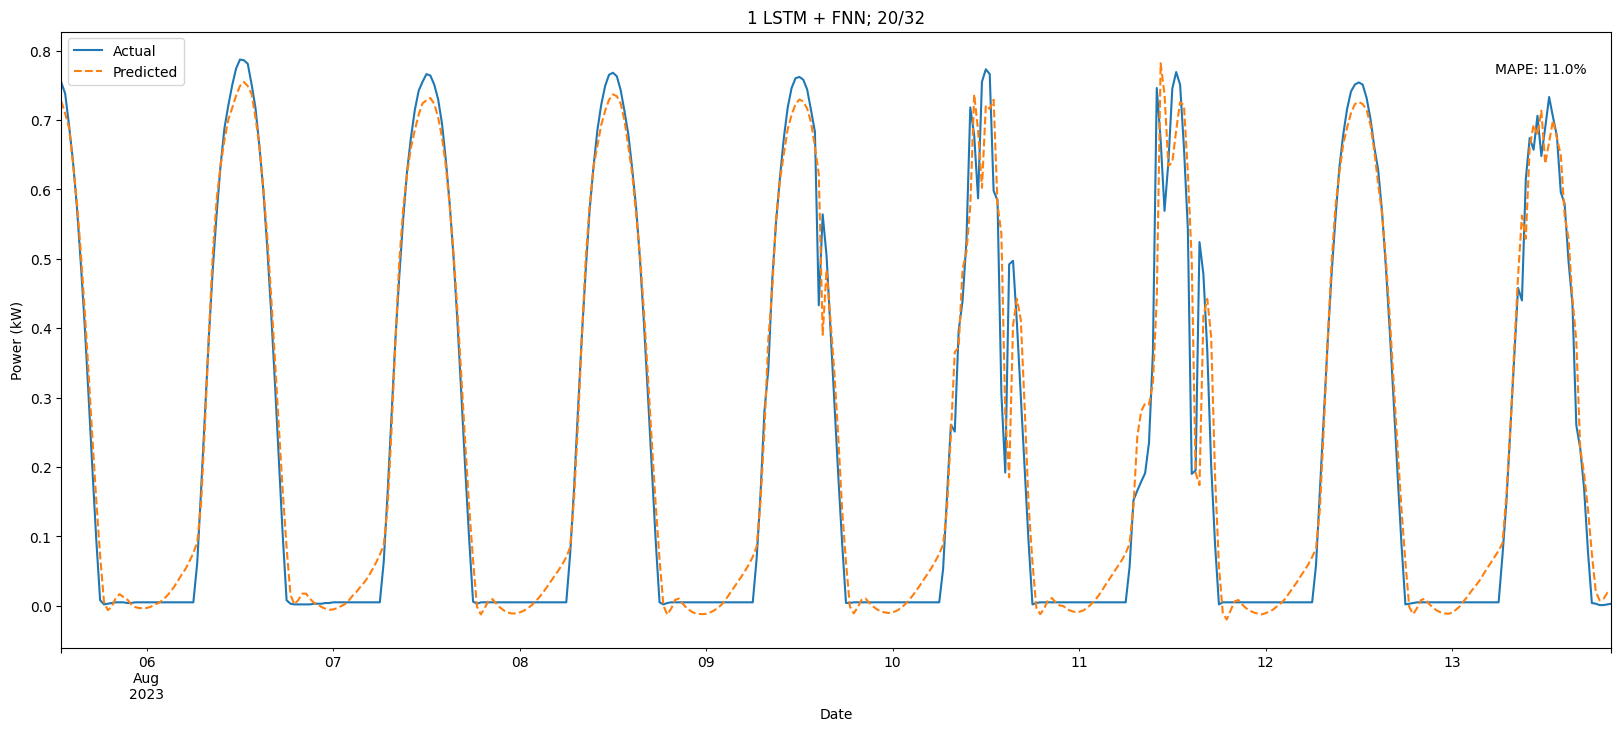

In [40]:
# Plot the data
_ = with_predicts[1700:2100].plot(x='Datetime', y=['Pac', 'Predictions'], figsize=(20,8), title="1 LSTM + FNN; 20/32", style=['-','--'])

# Add y-axis label
plt.ylabel('Power (kW)')

# Add x-axis label
plt.xlabel('Date')
plt.legend(['Actual', 'Predicted'])
# Display the error value
plt.text(0.925, 0.95, f"MAPE: {error:.1f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.show()
